# ResNet-50 with Neutrino Dataset

### Importing essential libraries
this will be cleaned, some are inessential

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
import sklearn
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

I check here if cuda gpu is available

In [3]:
torch.cuda.is_available()

True

## Model, Train, and Test

I define here the model (ResNet-50) and the train and test function. The model takes as input images channel first with 3 channels. The test definition is week and it could lead to a memory leak. 

In [4]:
#pred_list and target_list are two lists of cuda tensors containing respectively the predictions and the 
#target values. Each tensor will be test_batch_size in lenght. Each list will contain 
#(amount of test samples/test_batch_size)*epochs samples. E.g. with 10k test samples, test_batch_size = 1k and
#4 epochs you'll get a list of 40 elements, each element 1k. Further down these lists will be converted in arrays.

pred_list = []
target_list = []
accuracy = []
loss = []
epochs = 20
test_batch = 100
    
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(Bottleneck, [3,4,6,3], num_classes=3)
        self.conv1 = torch.nn.Conv2d(3, 64,
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
######if you then use nll_loss you have to use log_sotmax        
    def forward(self, x):
        return F.log_softmax(
            super(MnistResNet, self).forward(x), dim=-1)

        



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        output = None
        del output
        target = None
        del target
        length = len(data)
        data = None
        del data
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * length, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            data = None
            del data
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred_list.append(pred)
            target_list.append(target)
            output = None
            del output
            pred = None
            del pred
            
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy.append(100. * correct / len(test_loader.dataset))
    loss.append(test_loss)

## Dataset

I implemented here a simple dataset. At the moment, it takes a tensor as data and numpy array as target. Moreover, it only takes one file. This is something that I will need to change in the future since we have several files.

In [5]:
#implementing DataSet

class NeutrinoDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, x_tensor, y_tensor):
        #x_filenames = glob(x_path + '*.png') # Get the filenames of all training images
        
        #self.x_data = [torch.from_numpy(misc.imread(filename)) for filename in x_filenames] # Load the images into torch tensors
        #self.y_data = target_label_list # Class labels
        self.x_data = x_tensor
        self.y_data = y_tensor
        self.len = len(self.x_data)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len

## Importing files and preparing the dataset

In this part I import the train and test files, I normalize them and I reshape them to be channel first. This part could also lead to potential memory leaks. It would be nice to convert and normalise the numpy array in one go, but at the moment I can't.

In [7]:
import os

folder_x_train='/home/stefano/neutrino/data/final_array_x/train/'
directory_x_train=os.fsencode(folder_x_train)

folder_x_test='/home/stefano/neutrino/data/final_array_x/test/'
directory_x_test=os.fsencode(folder_x_test)

folder_y_train='/home/stefano/neutrino/data/final_array_y/train/'
directory_y_train=os.fsencode(folder_y_train)

folder_y_test='/home/stefano/neutrino/data/final_array_y/test/'
directory_y_test=os.fsencode(folder_y_test)

counter_a=0
counter_b=0
counter_c=0
counter_d=0

for file in os.listdir(directory_x_train):
    filename = os.fsdecode(file)
    path=folder_x_train+filename
    x_train=np.load(path)
    if counter_a==0:
        x_train_temp=x_train
        counter_a=counter_a+1
    elif counter_a>0:
        x_train_temp=np.concatenate((x_train_temp,x_train))
        counter_a=counter_a+1
    del filename
    del path
    del x_train
        
for file in os.listdir(directory_x_test):
    filename = os.fsdecode(file)
    path=folder_x_test+filename
    x_test=np.load(path)
    if counter_b==0:
        x_test_temp=x_test
        counter_b=counter_b+1
    elif counter_b>0:
        x_test_temp=np.concatenate((x_test_temp,x_test))
        counter_b=counter_b+1
    del filename
    del path
    del x_test

for file in os.listdir(directory_y_train):
    filename = os.fsdecode(file)
    path=folder_y_train+filename
    y_tr=np.load(path)
    if counter_c==0:
        y_train=y_tr
        counter_c=counter_c+1
    elif counter_c>0:
        y_train=np.concatenate((y_train,y_tr))
        counter_c=counter_c+1
    del filename
    del path
    del y_tr
    
for file in os.listdir(directory_y_test):
    filename = os.fsdecode(file)
    path=folder_y_test+filename
    y_ts=np.load(path)
    if counter_d==0:
        y_test=y_ts
        counter_d=counter_d+1
    elif counter_d>0:
        y_test=np.concatenate((y_test,y_ts))
        counter_d=counter_d+1
    del filename
    del path
    del y_ts
    
print(x_train_temp.shape)
print(x_test_temp.shape)
print(y_train.shape)
print(y_test.shape)

del counter_a
del counter_b
del counter_c
del counter_d

(3000, 200, 200, 3)
(1000, 200, 200, 3)
(3000,)
(1000,)


In [8]:
#passages are: x_train_temp -> x_train (min 0 max 1, float32) -> x_train_reshaped (channel first) -> x_train_tensor

#normalise the data
old_min = np.min(x_train_temp)
old_max = np.max(x_train_temp)
print("Before:", old_min, old_max)
x_train = x_train_temp.astype('float32')
x_test = x_test_temp.astype('float32')
x_train /=255
x_test /= 255
new_min = np.min(x_train)
new_max = np.max(x_train)
print("After:", new_min, new_max)

print("Test Data Shape after conversion to float")
    
    #read the dimensions from one example in the trainig set
img_rows, img_cols = x_train[0].shape[0], x_train[0].shape[1]
print(x_train[0].shape[0])
print(x_train[0].shape[1])

#read the dimensions from one example in the trainig set
img_rows, img_cols = x_train[0].shape[0], x_train[0].shape[1]

#Different NN libraries (e.g., TF) use different ordering of dimensions
#Here we set the "input shape" so that later the NN knows what shape to expect
x_train_reshaped = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
x_test_reshaped = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
input_shape = (3, img_rows, img_cols)

print("input_shape",input_shape)
print("x_train[0].shape[0]", x_train_reshaped[0].shape[0])
print("x_train[0].shape[1]", x_train_reshaped[0].shape[1])
print("x_train[0].shape[2]", x_train_reshaped[0].shape[2])
print("x_train.shape",x_train.shape)

x_train_tensor = torch.from_numpy(x_train_reshaped).float()
x_test_tensor = torch.from_numpy(x_test_reshaped).float()

x_train = None
del x_train
x_test = None
del x_test
x_train_reshaped = None
del x_train_reshaped
x_test_reshaped = None
del x_test_reshaped

y_train_tensor=torch.from_numpy(y_train)
y_test_tensor=torch.from_numpy(y_test)

#y_train = None
#del y_train
#y_test = None
#del y_test

dataset_test = NeutrinoDataset(x_test_tensor, y_test_tensor)

Before: 0 255
After: 0.0 1.0
Test Data Shape after conversion to float
200
200
input_shape (3, 200, 200)
x_train[0].shape[0] 3
x_train[0].shape[1] 200
x_train[0].shape[2] 200
x_train.shape (3000, 200, 200, 3)


## Definition of main function

I define here the dataset and the main function. This seems to be the stronger part of the code.

In [9]:
import easydict
def main():
    args = easydict.EasyDict({
        "batch_size": 16,#it was 64
        "test_batch_size": test_batch,
        "epochs": epochs,
        "lr": 1.0,
        "gamma": 0.7,
        "no_cuda": False,
        "seed": 1,
        "log_interval":10,
        "save_model": False
    })
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
    #device = torch.device("cpu")
    
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    

    
    transform_train=transforms.Compose([ToTensor(),transforms.Normalize((0.011209016666666667,), (0.36950463408735745,))])
    transform_test=transforms.Compose([ToTensor(),transforms.Normalize((0.0171563,), (0.5148277654099112,))]) 
    
   # x_train_tensor = transform_train(x_train)
    #x_test_tensor = transform_test(x_test)
    
    
    #x_train_tensor = transforms.Normalize((0.011209016666666667,), (0.36950463408735745,), x_train_temp)
    #x_test_tensor = transforms.Normalize((0.0171563,), (0.5148277654099112,), x_test_temp)
    
    dataset_train = NeutrinoDataset(x_train_tensor, y_train_tensor)
    dataset_test = NeutrinoDataset(x_test_tensor, y_test_tensor)
    
    train_loader = torch.utils.data.DataLoader(dataset=dataset_train,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test,
        batch_size=args.test_batch_size, shuffle=False, **kwargs)

    model = MnistResNet().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


### Plotting your Train and Test Dataset
It is important to always check your dataset. With the following lines images from your train and test dataset and randomly selected and plotted.

In this part I calcolate mean and std of the pics in case I find a way to use tensor.normalise. Skip this part when run the code.

## Visualisation

The following two cells contain a cool tool to visualise train and test dataset. Useful.

(3000, 200, 200, 3)
now showing image  521


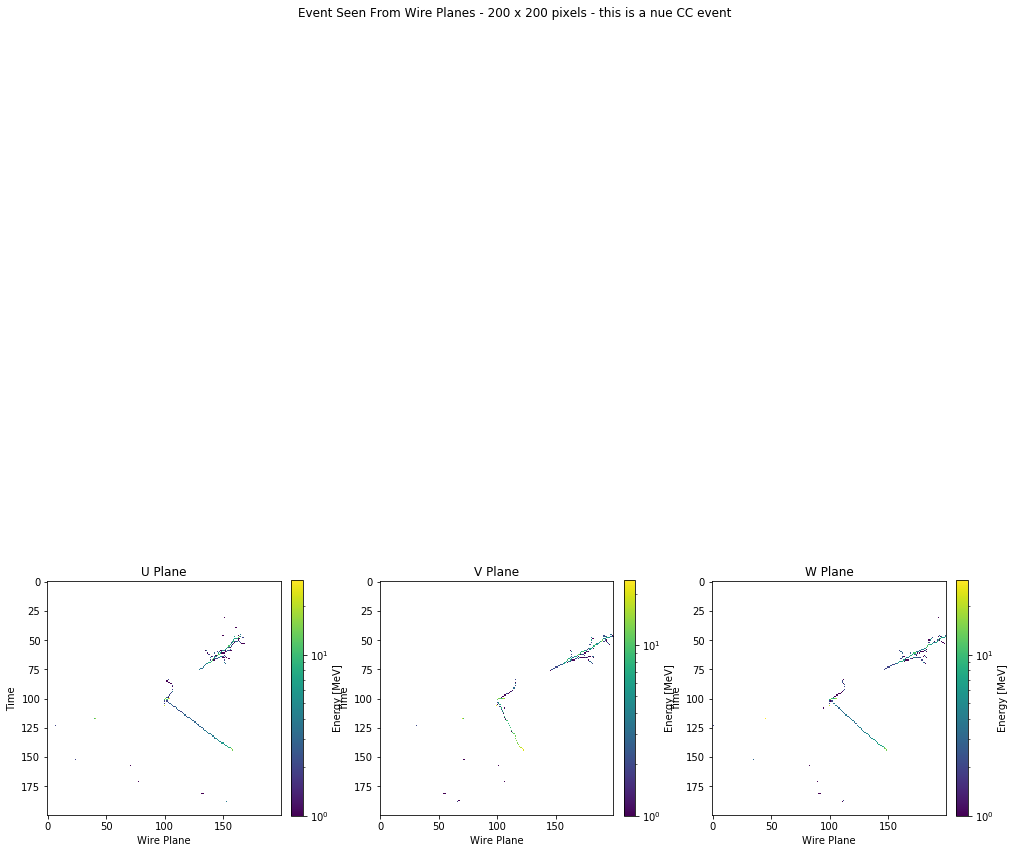

In [10]:
use_cuda =  torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
import zlib
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
figsize = [14, 20]
starting_number = torch.IntTensor.item(torch.LongTensor(1).random_(0, len(x_train_temp)-1))#-(nrows*ncols)))

print(x_train_temp.shape)
#if use_cuda == True:
#    x_train_cpu=x_train_temp.cpu()
#    y_train_cpu=y_train_tensor.cpu()
#else:
#    x_train_cpu=x_train_temp
#    y_train_cpu=y_train_tensor
    
print("now showing image ",(starting_number))

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth=y_train[starting_number]
if truth==0:
    truth_stg="NC"
elif truth==1:
    truth_stg="numu CC"
elif truth==2:
    truth_stg="nue CC"

a = x_train_temp[(starting_number),:,:,0]

b = x_train_temp[(starting_number),:,:,1]

c = x_train_temp[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

plt.show()
plt.close()


now showing image  402


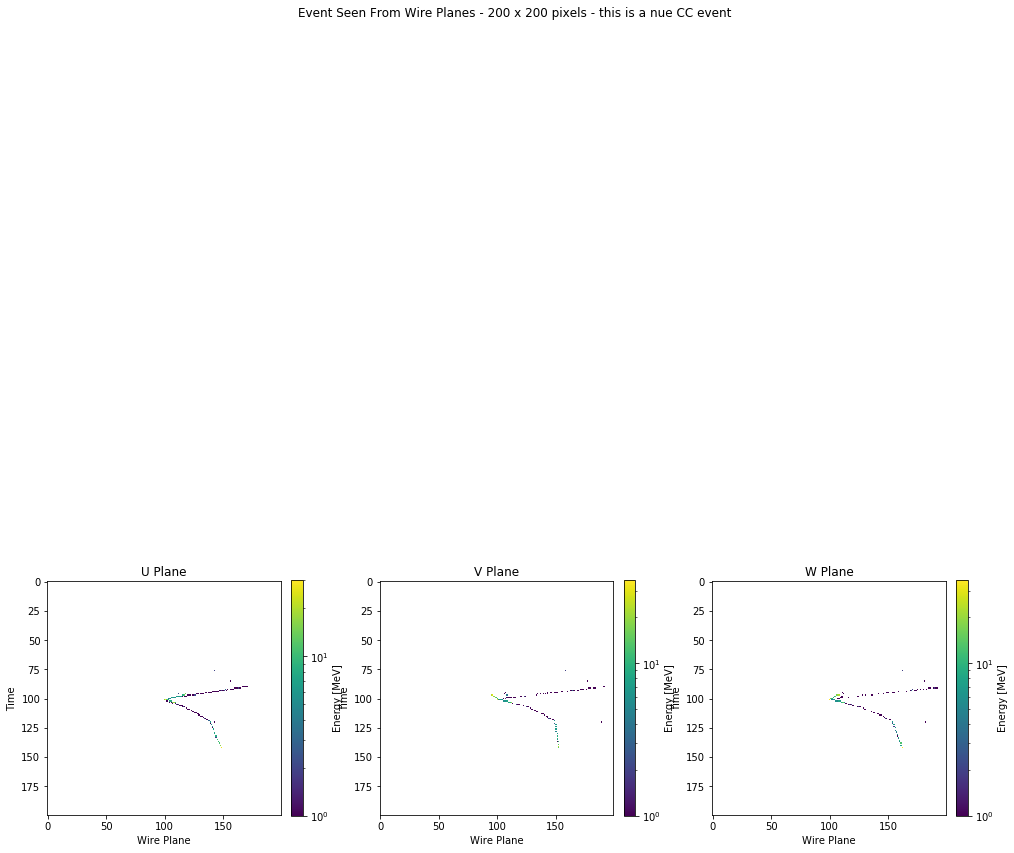

In [11]:
figsize = [14, 20]
starting_number = torch.IntTensor.item(torch.LongTensor(1).random_(0, len(x_test_temp)-1))#-(nrows*ncols)))
    
print("now showing image ",(starting_number))

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth=y_test[starting_number]
if truth==0:
    truth_stg="NC"
elif truth==1:
    truth_stg="numu CC"
elif truth==2:
    truth_stg="nue CC"

a = x_test_temp[(starting_number),:,:,0]

b = x_test_temp[(starting_number),:,:,1]

c = x_test_temp[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

plt.show()
plt.close()

Next cell could maybe help to clean some memory?

In [12]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

## Main Run

When GPU is used, it runs out of memory durign testing phase...

In [ ]:
start.record()
main()
end.record()

Train Epoch: 1 [0/3000 (0%)]	Loss: 1.036362
Train Epoch: 1 [160/3000 (5%)]	Loss: 3.392673
Train Epoch: 1 [320/3000 (11%)]	Loss: 1.128612
Train Epoch: 1 [480/3000 (16%)]	Loss: 2.735526
Train Epoch: 1 [640/3000 (21%)]	Loss: 1.023634
Train Epoch: 1 [800/3000 (27%)]	Loss: 1.151068
Train Epoch: 1 [960/3000 (32%)]	Loss: 1.221431
Train Epoch: 1 [1120/3000 (37%)]	Loss: 1.050296
Train Epoch: 1 [1280/3000 (43%)]	Loss: 1.029763
Train Epoch: 1 [1440/3000 (48%)]	Loss: 1.633978
Train Epoch: 1 [1600/3000 (53%)]	Loss: 1.178122
Train Epoch: 1 [1760/3000 (59%)]	Loss: 1.188928
Train Epoch: 1 [1920/3000 (64%)]	Loss: 1.068901
Train Epoch: 1 [2080/3000 (69%)]	Loss: 1.031285
Train Epoch: 1 [2240/3000 (74%)]	Loss: 1.046267
Train Epoch: 1 [2400/3000 (80%)]	Loss: 0.871414
Train Epoch: 1 [2560/3000 (85%)]	Loss: 1.183955
Train Epoch: 1 [2720/3000 (90%)]	Loss: 1.240345
Train Epoch: 1 [2880/3000 (96%)]	Loss: 1.148591

Test set: Average loss: 1.2411, Accuracy: 292/1000 (29%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 1.241

In [ ]:
print(start.elapsed_time(end))

In [ ]:
#resnet50 size 200x200 with cpu (25-02-2020) batch size 1
# with cpu is was 3717510.25 ms, that is ~3717 s ~ 1 h for 6 epochs - final test set batch size 1
# Test set: Average loss: 3.5087, Accuracy: 487/1000 (49%)

#resnet50 size 200x200 with gpu (25-02-2020) batch size 1
# with gpu is was 381100.1875 ms, that is ~381 s ~ 6 and a half min for 6 epochs - final test set batch size 1
# Test set: Average loss: 2.9999, Accuracy: 499/1000 (50%)

#resnet50 size 200x200 with gpu (25-02-2020) batch size 16
# with gpu is was 329710.28125 ms, that is ~329 s ~ 5 min for 20 epochs - final test set batch size 100
# Test set: Average loss: 1.2409, Accuracy: 664/1000 (66%)

In [ ]:
epochs_array = []
for i in range (1,epochs+1):
    epochs_array.append(i)
    
accuracy=np.array(accuracy)
accuracy=accuracy/100
epochs_array = np.array(epochs_array)
loss = np.array(loss)
plt.figure(figsize = (10,7))
plt.subplot(1, 2, 1)
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_array,accuracy)
plt.subplot(1, 2, 2)
plt.title('Total Loss vs. Epoch')
plt.ylabel('Total Loss')
plt.xlabel('Epoch')
plt.plot(epochs_array,loss,color='C1')
plt.tight_layout()

plt.show()



In [ ]:
pred_array_total = [] # array containing all predictions for all epochs
pred_array = [] #array containing only predictions of last epoch
for i in range(len(pred_list)):
    pred_array_total.append(pred_list[i].cpu().numpy())
    
pred_array_total=np.array(pred_array_total)
pred_array_total=np.squeeze(np.concatenate(pred_array_total))
#print(epochs*test_batch)
for i in range ((epochs*(1000)-1000),(epochs*1000)):
    pred_array.append(pred_array_total[i])
    
pred_array=np.array(pred_array)
pred_array.shape

In [ ]:
target_array_total = []#array containing all the targets for all epochs
target_array = []#array containing targets for last epoch
for i in range(len(target_list)):
    target_array_total.append(target_list[i].cpu().numpy())
    
target_array_total=np.array(target_array_total)
target_array_total=np.squeeze(np.concatenate(target_array_total))

for i in range ((epochs*1000)-1000,epochs*1000):
    target_array.append(target_array_total[i])
    
target_array=np.array(target_array)
target_array.shape

In [ ]:
import random
wrong_list = []
for i in range(len(target_array)):
    if target_array[i]!=pred_array[i]:
        wrong_list.append(i)
        
element=random.choice(wrong_list)
print('This was supposed to be ',target_array[element],' but it was predicted as ',pred_array[element])
x, _ = dataset_test[element] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

a = x_test_temp[(starting_number),:,:,0]

b = x_test_temp[(starting_number),:,:,1]

c = x_test_temp[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

In [ ]:
from __future__ import print_function
torch.set_printoptions(linewidth = 120)
import sklearn
#print(sklearn.__version__)
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix


plt.figure(figsize=(50,50))
cm=sklearn.metrics.confusion_matrix(target_array, pred_array,normalize='all')#, classes=label_dict,
                     #title='Confusion matrix')
cm
#plt.show()

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (14,10))
sn.heatmap(df_cm, annot=True)